In [2]:
import pandas as pd # for DataFrames
from scipy.stats import mannwhitneyu

Mann-Whitney U-Statistik: 11.0
P-Wert (einseitig): 0.0210


/tmp/ipykernel_378340/3448264124.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


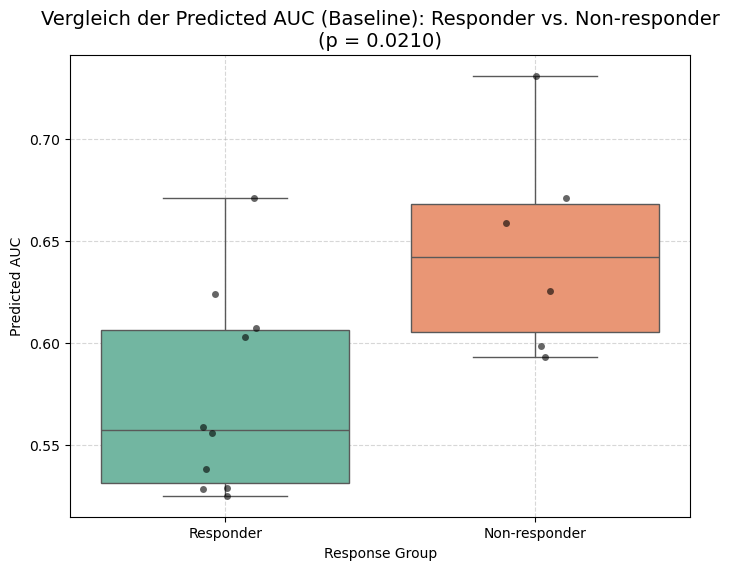

In [2]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='less')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (Baseline): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

Hypothese : Die Predicted_AUC-Werte der Responders sind kleiner (also besser) als die der Non-responder.
Es gibt statistisch signifikante Hinweise , dass die AUC-Werte bei Respondern tatsächlich systematisch niedriger  sind als bei Non-respondern. 

alternative='less' ist korrekt gewählt, wenn du testen willst, ob die vorhergesagte AUC bei Respondern signifikant niedriger ist als bei Non-Respondern (was Sinn ergibt, da niedrigere AUC = höhere Sensitivität).

Die Kurve zeigt typischerweise die Wachstumshemmung eines Tumors / Zelllinie  über verschiedenen Medikamentendosen. 
- Die Fläche unter dieser Kurve (AUC) repräsentiert, wie viel Dosis erforderlich ist, um eine Wirkung zu erzielen 
- Ein niedriger AUC-Wert  = Wenig Dosis notwendig → hohe Empfindlichkeit  → gutes Ansprechen 
- Ein hoher AUC-Wert  = Viel Dosis notwendig → geringe Empfindlichkeit  → schlechtes Ansprechen 
     



Mann-Whitney U-Statistik: 12.0
P-Wert (einseitig): 0.0280


/tmp/ipykernel_451346/1206162715.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


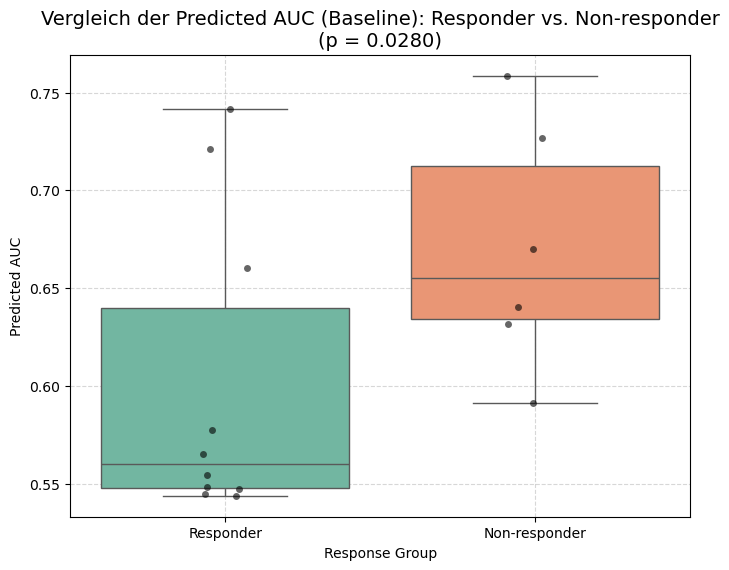

In [9]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_bce_loss_new_parameter_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='less')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (Baseline): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

# Drug-Gene-Interactions

Mann-Whitney U-Statistik: 27.0
P-Wert (einseitig): 0.3962


/tmp/ipykernel_378340/3669789293.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


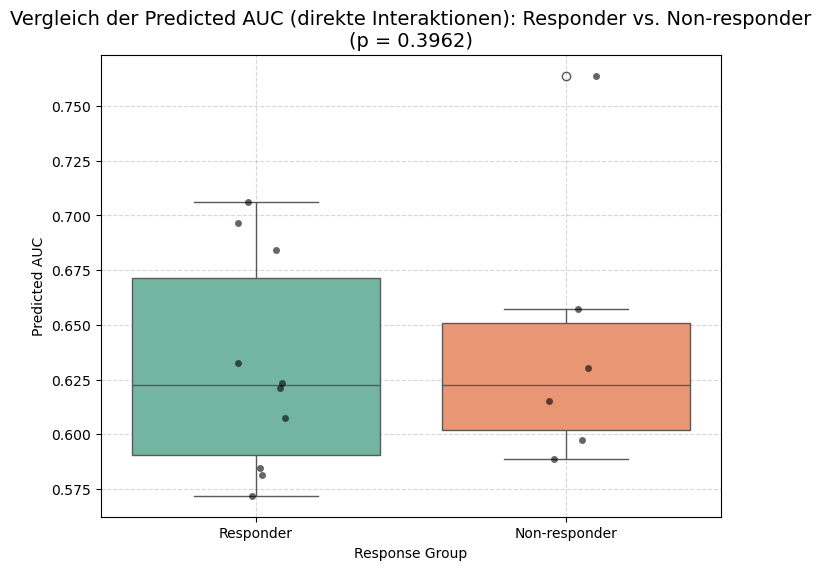

In [7]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_direct_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='less')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (direkte Interaktionen): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

Mann-Whitney U-Statistik: 16.0
P-Wert (einseitig): 0.0736


/tmp/ipykernel_451346/2625299842.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


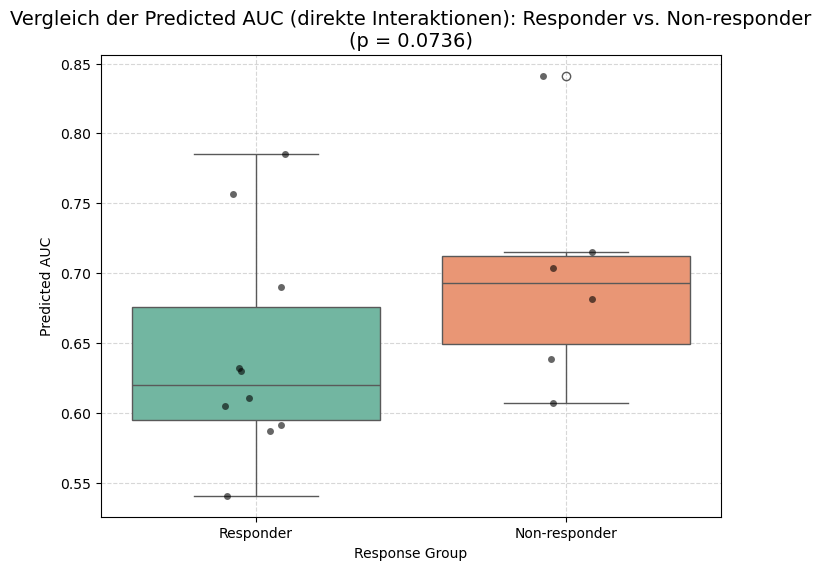

In [10]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_direct_bce_loss_new_parameter_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='less')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (direkte Interaktionen): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

Mann-Whitney U-Statistik: 40.0
P-Wert (einseitig): 0.1566


/tmp/ipykernel_378340/126968542.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


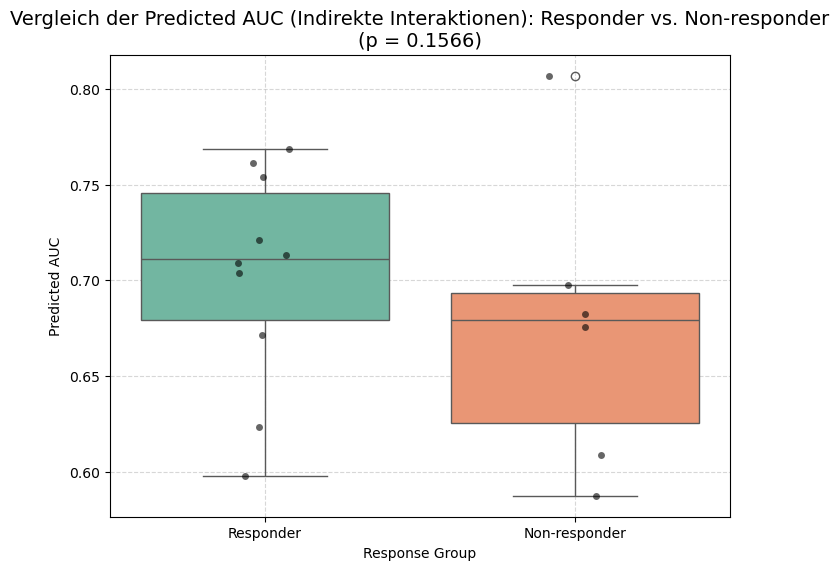

In [10]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_indirect_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='greater')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (Indirekte Interaktionen): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

Mann-Whitney U-Statistik: 36.0
P-Wert (einseitig): 0.2811


/tmp/ipykernel_451346/1789209431.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


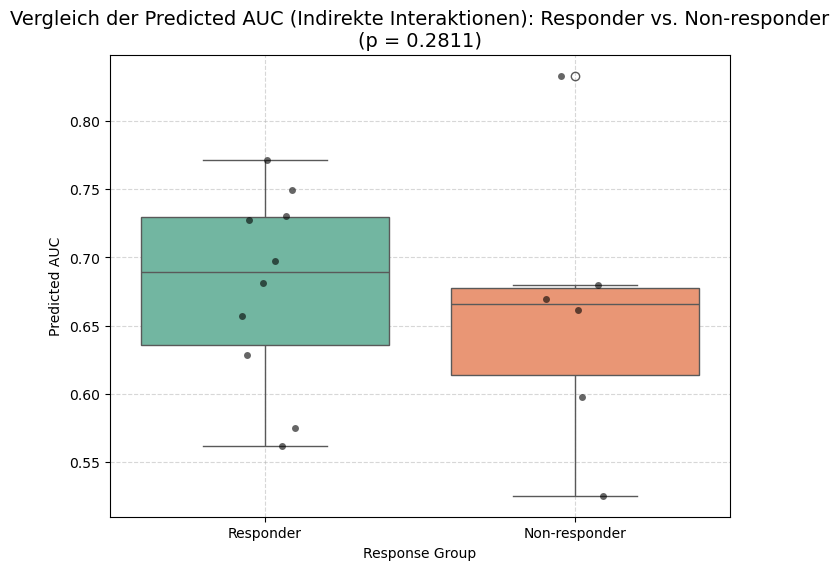

In [11]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_indirect_bce_loss_new_parameter_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='greater')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (Indirekte Interaktionen): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

# Drug-Pathway-Interaktionen

Mann-Whitney U-Statistik: 24.0
P-Wert (einseitig): 0.2811


/tmp/ipykernel_378340/3773426178.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


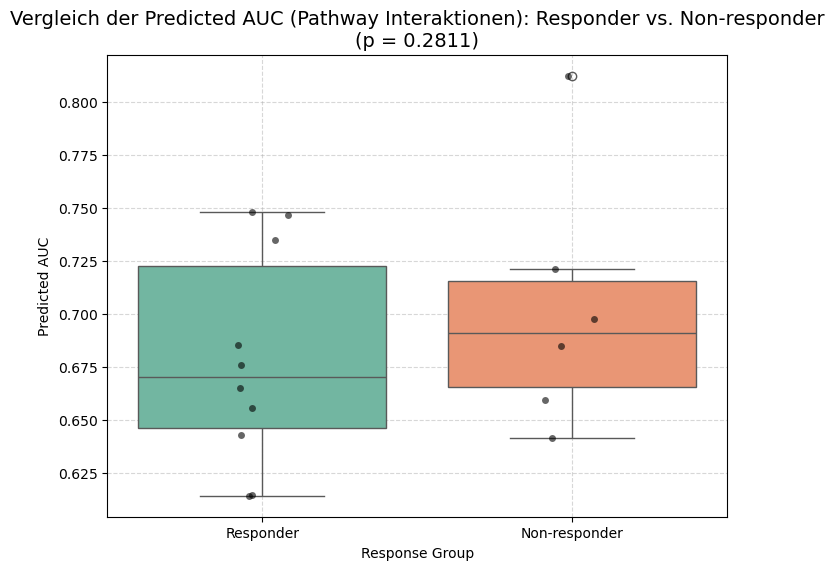

In [11]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_pathway_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='less')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (Pathway Interaktionen): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

Mann-Whitney U-Statistik: 16.0
P-Wert (einseitig): 0.0736


/tmp/ipykernel_451346/3022039223.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


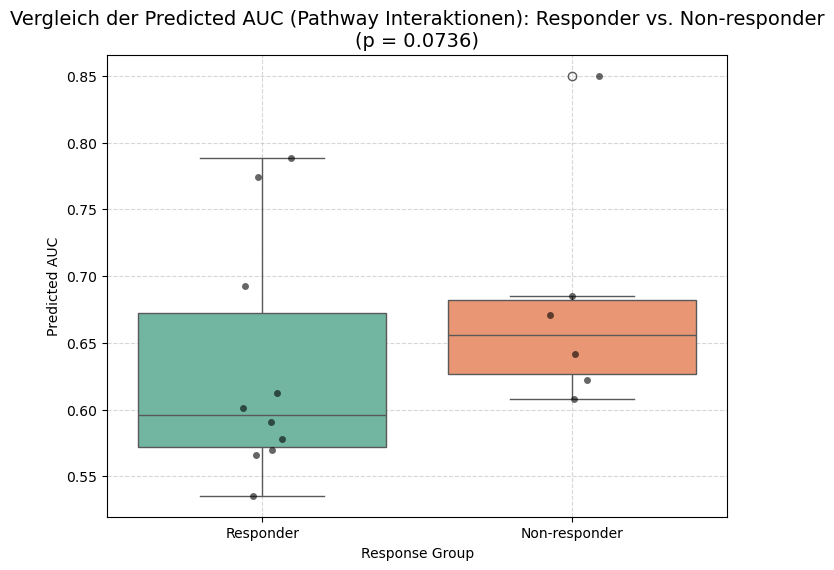

In [12]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_pathway_bce_loss_new_parameter_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='less')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (Pathway Interaktionen): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

Mann-Whitney U-Statistik: 16.0
P-Wert (einseitig): 0.0736


/tmp/ipykernel_451346/3350791414.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


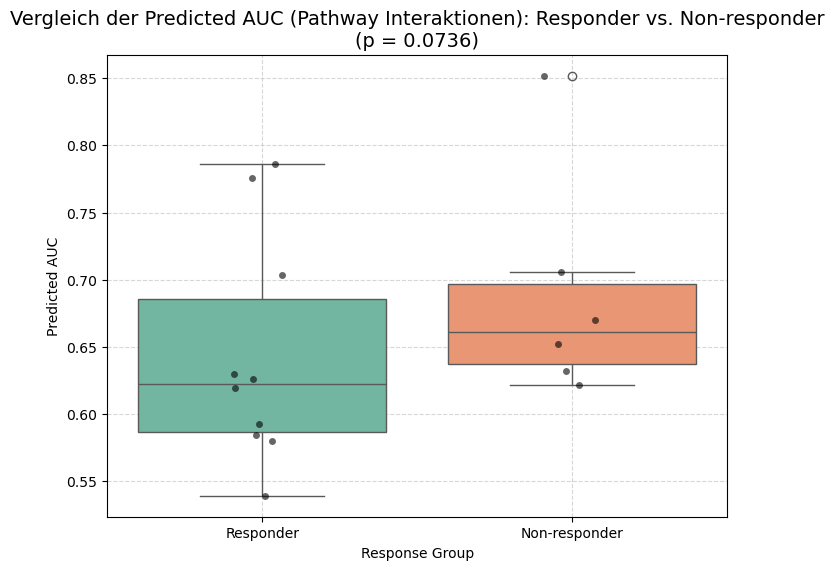

In [13]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_pathway_count_bce_loss_new_parameter_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='less')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (Pathway Interaktionen): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

Mann-Whitney U-Statistik: 19.0
P-Wert (einseitig): 0.1317


/tmp/ipykernel_451346/2576862803.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")


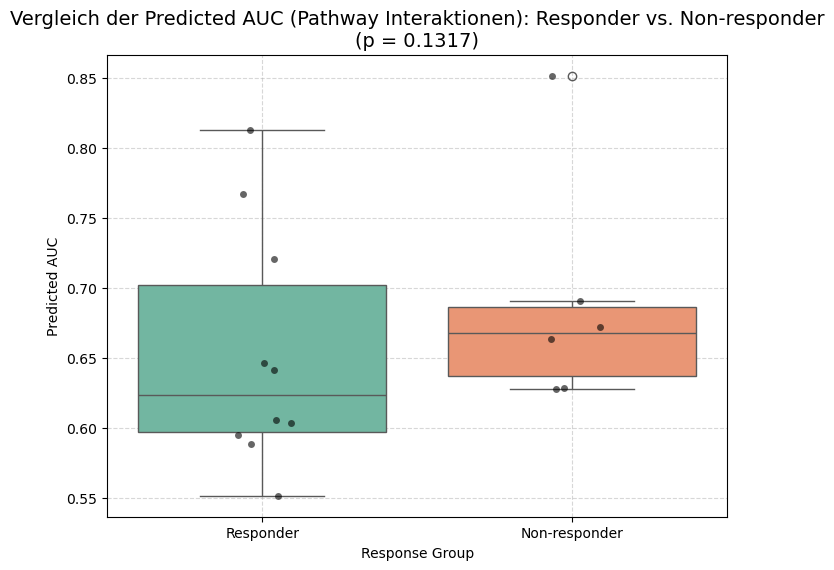

In [14]:
preds_AUC_Goe =  pd.read_csv("./results/DA/UMG/preds_AUC_pathway_weight_bce_loss_new_parameter_Goe.csv", index_col=0)
pdx_dataset = pd.read_csv('./data/PDX_UMG_Final.csv', index_col=0)
preds_AUC_Goe['Gemcitabine_Responder'] = pdx_dataset['Gemcitabine']

responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 1]['Gemcitabine'] # Predicted_AUC for Responder
non_responders = preds_AUC_Goe[preds_AUC_Goe['Gemcitabine_Responder'] == 0]['Gemcitabine'] # Predicted_AUC for Non-Responder

stat, p_value = mannwhitneyu(responders, non_responders, alternative='less')

# Ergebnis ausgeben
print(f"Mann-Whitney U-Statistik: {stat}")
print(f"P-Wert (einseitig): {p_value:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Neue Spalte für Response-Gruppen erstellen
preds_AUC_Goe['Response_Group'] = preds_AUC_Goe['Gemcitabine_Responder'].map({1: 'Responder', 0: 'Non-responder'})

# Boxplot erstellen
plt.figure(figsize=(8, 6))
sns.boxplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, palette="Set2")
sns.stripplot(x='Response_Group', y='Gemcitabine', data=preds_AUC_Goe, color="black", jitter=True, alpha=0.6)

# Titel und Labels
plt.title('Vergleich der Predicted AUC (Pathway Interaktionen): Responder vs. Non-responder\n(p = {:.4f})'.format(p_value), fontsize=14)
plt.ylabel('Predicted AUC')
plt.xlabel('Response Group')
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.show()

# Weitere Metriken

In [18]:
from sklearn.metrics import roc_curve, classification_report, roc_auc_score

# Lade Daten für das beste Modell
file_path = "./results/DA/UMG/preds_AUC_indirect_bce_loss_new_parameter_Goe.csv"
preds = pd.read_csv(file_path, index_col=0)

# Labels & Scores
y_true = pdx_dataset['Gemcitabine']
y_scores = preds['Gemcitabine']

# Bereinigen der NaNs
valid_indices = y_true.notna() & y_scores.notna()
y_true_clean = y_true[valid_indices]
y_scores_clean = y_scores[valid_indices]

# ROC-AUC
roc_auc = roc_auc_score(y_true_clean, y_scores_clean)

# ROC-Kurve
fpr, tpr, thresholds = roc_curve(y_true_clean, y_scores_clean)
j_scores = tpr - fpr
best_idx = j_scores.argmax()
best_threshold = thresholds[best_idx]

# Vorhersage basierend auf Threshold
y_pred = (y_scores_clean <= best_threshold).astype(int)

# Ausgabe
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_clean, y_pred))

ROC-AUC: 0.6000
Best Threshold: 0.6809

Classification Report:
              precision    recall  f1-score   support

         0.0       0.17      0.17      0.17         6
         1.0       0.50      0.50      0.50        10

    accuracy                           0.38        16
   macro avg       0.33      0.33      0.33        16
weighted avg       0.38      0.38      0.38        16



In [17]:
from sklearn.metrics import roc_curve, classification_report, roc_auc_score

# Lade Daten für das beste Modell
file_path = "./results/DA/UMG/preds_AUC_direct_bce_loss_new_parameter_Goe.csv"
preds = pd.read_csv(file_path, index_col=0)

# Labels & Scores
y_true = pdx_dataset['Gemcitabine']
y_scores = preds['Gemcitabine']

# Bereinigen der NaNs
valid_indices = y_true.notna() & y_scores.notna()
y_true_clean = y_true[valid_indices]
y_scores_clean = y_scores[valid_indices]

# ROC-AUC
roc_auc = roc_auc_score(y_true_clean, y_scores_clean)

# ROC-Kurve
fpr, tpr, thresholds = roc_curve(y_true_clean, y_scores_clean)
j_scores = tpr - fpr
best_idx = j_scores.argmax()
best_threshold = thresholds[best_idx]

# Vorhersage basierend auf Threshold
y_pred = (y_scores_clean <= best_threshold).astype(int)

# Ausgabe
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_clean, y_pred))

ROC-AUC: 0.2667
Best Threshold: 0.7567

Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.17      0.25         6
         1.0       0.64      0.90      0.75        10

    accuracy                           0.62        16
   macro avg       0.57      0.53      0.50        16
weighted avg       0.59      0.62      0.56        16



In [20]:
from sklearn.metrics import roc_curve, classification_report, roc_auc_score

# Lade Daten für das beste Modell
file_path = "./results/DA/UMG/preds_AUC_bce_loss_new_parameter_Goe.csv"
preds = pd.read_csv(file_path, index_col=0)

# Labels & Scores
y_true = pdx_dataset['Gemcitabine']
y_scores = preds['Gemcitabine']

# Bereinigen der NaNs
valid_indices = y_true.notna() & y_scores.notna()
y_true_clean = y_true[valid_indices]
y_scores_clean = y_scores[valid_indices]

# ROC-AUC
roc_auc = roc_auc_score(y_true_clean, y_scores_clean)

# ROC-Kurve
fpr, tpr, thresholds = roc_curve(y_true_clean, y_scores_clean)
j_scores = tpr - fpr
best_idx = j_scores.argmax()
best_threshold = thresholds[best_idx]

# Vorhersage basierend auf Threshold
y_pred = (y_scores_clean <= best_threshold).astype(int)

# Ausgabe
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_clean, y_pred))

ROC-AUC: 0.2000
Best Threshold: inf

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.62      1.00      0.77        10

    accuracy                           0.62        16
   macro avg       0.31      0.50      0.38        16
weighted avg       0.39      0.62      0.48        16



/sybig/home/tmu/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/sybig/home/tmu/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/sybig/home/tmu/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
